# Quantitative Momentum Strategy

"Momentum investing" means investing in the stocks that have increased in price the most.

For this project, we're going to build an investing strategy that selects the 50 stocks with the highest price momentum. From there, we will calculate recommended trades for an equal-weight portfolio of these 50 stocks.


## Library Imports

The first thing we need to do is import the open-source software libraries that we'll be using in this tutorial.

In [47]:
import numpy as np
import pandas as pd
import requests
import math
from scipy import stats
import xlsxwriter
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta

## Importing Our List of Stocks

As before, we'll need to import our list of stocks and our API token before proceeding. Make sure the `.csv` file is still in your working directory and import it with the following command:

In [2]:
stocks = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
stocks = stocks[['Symbol', 'Security']]
stocks = stocks.rename(columns={'Symbol': 'Ticker', 'Security': 'Name'})
stocks

,Ticker,Name
0,MMM,3M
1,AOS,A. O. Smith
2,ABT,Abbott
3,ABBV,AbbVie
4,ACN,Accenture
...,...,...
498,XYL,Xylem Inc.
499,YUM,Yum! Brands
500,ZBRA,Zebra Technologies
501,ZBH,Zimmer Biomet


## Making Our First API Call

It's now time to make the first version of our momentum screener!

We need to get one-year price returns for each stock in the universe. Here's how.

<Axes: title={'center': 'AAPL 5 Year Price Chart'}, xlabel='Date'>

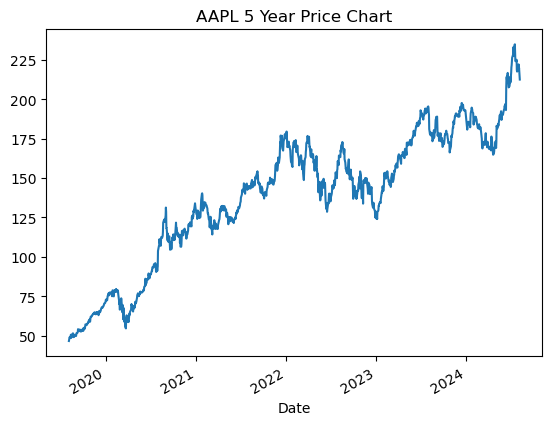

In [11]:
ticker = yf.Ticker("AAPL")
aapl_df = ticker.history(period = "5y")
aapl_df['Close'].plot(title = 'AAPL 5 Year Price Chart')

## Parsing Our API Call

This API call has all the information we need. We can parse it using the same square-bracket notation as in the first project of this course. Here is an example.

In [29]:
print('52 Week Change: ', ticker.info['52WeekChange'])
print('Close Price:', ticker.history('1d')['Close'].iloc[0])
ticker.info

52 Week Change:  0.22929835
Close Price: 211.8000030517578


{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

## Executing A Batch API Call & Building Our DataFrame

Just like in our first project, it's now time to execute several batch API calls and add the information we need to our DataFrame.

We'll start by running the following code cell, which contains some code we already built last time that we can re-use for this project. More specifically, it contains a function called `chunks` that we can use to divide our list of securities into groups of 100.

In [15]:
# Function sourced from 
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]   
        
symbol_groups = list(chunks(stocks['Ticker'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))
#     print(symbol_strings[i])


my_columns = ['Ticker', 'Price', 'One-Year Price Return', 'Number of Shares to Buy']

Now we need to create a blank DataFrame and add our data to the data frame one-by-one.

In [31]:
final_dataframe = pd.DataFrame(columns=my_columns)

def fetch_stock_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        history = stock.history(period='1d')
        info = stock.info
        
        if not history.empty:
            price = history['Close'].iloc[0]
            year_change = stock.info['52WeekChange']
        else:
            price = None
            year_change = None
        
        return pd.Series(
            [
                ticker,
                price,
                year_change,
                'N/A'
            ],
            index=my_columns
        )
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.Series([ticker, None, None, 'N/A'], index=my_columns)

# Using ThreadPoolExecutor to fetch data concurrently
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(fetch_stock_data, ticker) for ticker in stocks['Ticker']]
    
    for future in as_completed(futures):
        final_dataframe = pd.concat([final_dataframe, future.result().to_frame().T], ignore_index=True)

BRK.B: No data found, symbol may be delisted
BF.B: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']


In [32]:
final_dataframe

,Ticker,Price,One-Year Price Return,Number of Shares to Buy
0,ABBV,186.164993,0.259163,N/A
1,ACN,316.227509,0.023047,N/A
2,AOS,82.425003,0.115926,N/A
3,MMM,123.885002,0.423425,N/A
4,ABT,109.760002,0.026372,N/A
...,...,...,...,...
498,XYL,128.455002,0.21681,N/A
499,YUM,134.024994,0.000518,N/A
500,ZBRA,319.649994,0.298393,N/A
501,ZBH,108.089996,-0.121547,N/A


## Removing Low-Momentum Stocks

The investment strategy that we're building seeks to identify the 50 highest-momentum stocks in the S&P 500.

Because of this, the next thing we need to do is remove all the stocks in our DataFrame that fall below this momentum threshold. We'll sort the DataFrame by the stocks' one-year price return, and drop all stocks outside the top 50.


In [36]:
final_dataframe.sort_values('One-Year Price Return', ascending=False, inplace=True)
final_dataframe = final_dataframe[:50]
final_dataframe.reset_index(drop=True, inplace=True)
final_dataframe

,Ticker,Price,One-Year Price Return,Number of Shares to Buy
0,VST,71.379997,1.523693,N/A
1,NVDA,103.029999,1.361891,N/A
2,GDDY,148.080002,1.134491,N/A
3,NRG,69.879997,0.865672,N/A
4,FICO,1588.26001,0.858163,N/A
5,HWM,87.269997,0.787116,N/A
6,ANET,316.484985,0.781335,N/A
7,LLY,792.580017,0.771626,N/A
8,SMCI,622.284973,0.768094,N/A
9,KKR,107.559998,0.757321,N/A


## Calculating the Number of Shares to Buy

Just like in the last project, we now need to calculate the number of shares we need to buy. The one change we're going to make is wrapping this functionality inside a function, since we'll be using it again later in this Jupyter Notebook.

Since we've already done most of the work on this, try to complete the following two code cells without watching me do it first!

In [41]:
def portfolio_input():
    global portfolio_size
    portfolio_size = input('Enter the value of your portfolio:')

    try:
        portfolio_size = float(portfolio_size)
    except ValueError:
        print('Please enter a number')
        portfolio_size = input('Enter the value of your portfolio:')

portfolio_input()
print('Portfolio Size: ', "{:,}".format(portfolio_size))

Portfolio Size:  1,000,000.0


In [44]:
position_size = portfolio_size / len(final_dataframe.index)

for i in range(0, len(final_dataframe.index)):
    final_dataframe.loc[i, 'Number of Shares to Buy'] = math.floor(position_size / final_dataframe.loc[i, 'Price'])

final_dataframe

,Ticker,Price,One-Year Price Return,Number of Shares to Buy
0,VST,71.379997,1.523693,280
1,NVDA,103.029999,1.361891,194
2,GDDY,148.080002,1.134491,135
3,NRG,69.879997,0.865672,286
4,FICO,1588.26001,0.858163,12
5,HWM,87.269997,0.787116,229
6,ANET,316.484985,0.781335,63
7,LLY,792.580017,0.771626,25
8,SMCI,622.284973,0.768094,32
9,KKR,107.559998,0.757321,185


## Building a Better (and More Realistic) Momentum Strategy

Real-world quantitative investment firms differentiate between "high quality" and "low quality" momentum stocks:

* High-quality momentum stocks show "slow and steady" outperformance over long periods of time
* Low-quality momentum stocks might not show any momentum for a long time, and then surge upwards.

The reason why high-quality momentum stocks are preferred is because low-quality momentum can often be cause by short-term news that is unlikely to be repeated in the future (such as an FDA approval for a biotechnology company).

To identify high-quality momentum, we're going to build a strategy that selects stocks from the highest percentiles of: 

* 1-month price returns
* 3-month price returns
* 6-month price returns
* 1-year price returns

Let's start by building our DataFrame. You'll notice that I use the abbreviation `hqm` often. It stands for `high-quality momentum`.

In [46]:
hqm_columns = [
    'Ticker',
    'Price',
    'Number of Shares to Buy',
    'One-Year Price Return',
    'One-Year Return Percentile',
    'Six-Month Price Return',
    'Six-Month Return Percentile',
    'Three-Month Price Return',
    'Three-Month Return Percentile',
    'One-Month Price Return',
    'One-Month Return Percentile',

]

hqm_dataframe = pd.DataFrame(columns=hqm_columns)
hqm_dataframe


,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile


In [78]:
hqm_dataframe = pd.DataFrame(columns=hqm_columns)

def fetch_stock_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        history = stock.history(period='6mo')  # Fetch only the last 6 months of data
        info = stock.info
        
        if not history.empty:
            price = history['Close'].iloc[-1]

            # Calculate returns
            end_date = history.index[-1]
            one_month_ago = end_date - timedelta(days=30)
            three_months_ago = end_date - timedelta(days=90)
            six_months_ago = end_date - timedelta(days=180)

            def calc_return(date):
                nearest_date = history.index.searchsorted(date)
                if nearest_date < len(history):
                    return (price - history['Close'].iloc[nearest_date]) / history['Close'].iloc[nearest_date]
                return None

            one_month_return = calc_return(one_month_ago)
            three_month_return = calc_return(three_months_ago)
            six_month_return = calc_return(six_months_ago)
            one_year_return = info.get('52WeekChange', None)
        else:
            price = None
            one_month_return = None
            three_month_return = None
            six_month_return = None
            one_year_return = None

        return pd.Series(
            [
                ticker,
                price,
                'N/A',
                one_year_return,
                'N/A',
                six_month_return,
                'N/A',
                three_month_return,
                'N/A',
                one_month_return,
                'Fetched'
            ],
            index=hqm_columns
        )
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.Series([ticker, None, None, None, 'N/A', None, 'N/A', None, 'N/A', None, 'Error'], index=hqm_columns)

# Using ThreadPoolExecutor to fetch data concurrently
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(fetch_stock_data, ticker) for ticker in stocks['Ticker']]
    
    for future in as_completed(futures):
        hqm_dataframe = pd.concat([hqm_dataframe, future.result().to_frame().T], ignore_index=True)

hqm_dataframe

BRK.B: No data found, symbol may be delisted
$BF.B: possibly delisted; No price data found  (period=6mo)


$BF.B: possibly delisted; No price data found  (period=6mo)


SW: Period '6mo' is invalid, must be one of ['1d', '5d', '1mo', 'ytd', 'max']


,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile
0,AMD,134.929993,N/A,0.134321,N/A,-0.210659,N/A,-0.126271,N/A,-0.244893,Fetched
1,ABBV,183.649994,N/A,0.259163,N/A,0.068898,N/A,0.140185,N/A,0.113002,Fetched
2,ADBE,508.480011,N/A,-0.00672,N/A,-0.174344,N/A,0.032929,N/A,-0.116302,Fetched
3,A,134.050003,N/A,0.099044,N/A,0.013005,N/A,-0.049347,N/A,0.063298,Fetched
4,AOS,81.459999,N/A,0.115926,N/A,0.02808,N/A,-0.040528,N/A,0.008712,Fetched
...,...,...,...,...,...,...,...,...,...,...,...
498,YUM,132.285004,N/A,0.000518,N/A,0.030549,N/A,-0.021889,N/A,0.033961,Fetched
499,XYL,126.184998,N/A,0.21681,N/A,0.028651,N/A,-0.096514,N/A,-0.058742,Fetched
500,ZBRA,317.920013,N/A,0.298393,N/A,0.286553,N/A,0.000157,N/A,0.010939,Fetched
501,ZBH,107.165001,N/A,-0.121547,N/A,-0.156369,N/A,-0.115514,N/A,0.007285,Fetched


In [80]:
hqm_dataframe = hqm_dataframe[~hqm_dataframe.isnull().any(axis=1)]
hqm_dataframe

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile
0,AMD,134.929993,N/A,0.134321,N/A,-0.210659,N/A,-0.126271,N/A,-0.244893,Fetched
1,ABBV,183.649994,N/A,0.259163,N/A,0.068898,N/A,0.140185,N/A,0.113002,Fetched
2,ADBE,508.480011,N/A,-0.00672,N/A,-0.174344,N/A,0.032929,N/A,-0.116302,Fetched
3,A,134.050003,N/A,0.099044,N/A,0.013005,N/A,-0.049347,N/A,0.063298,Fetched
4,AOS,81.459999,N/A,0.115926,N/A,0.02808,N/A,-0.040528,N/A,0.008712,Fetched
...,...,...,...,...,...,...,...,...,...,...,...
498,YUM,132.285004,N/A,0.000518,N/A,0.030549,N/A,-0.021889,N/A,0.033961,Fetched
499,XYL,126.184998,N/A,0.21681,N/A,0.028651,N/A,-0.096514,N/A,-0.058742,Fetched
500,ZBRA,317.920013,N/A,0.298393,N/A,0.286553,N/A,0.000157,N/A,0.010939,Fetched
501,ZBH,107.165001,N/A,-0.121547,N/A,-0.156369,N/A,-0.115514,N/A,0.007285,Fetched


## Calculating Momentum Percentiles

We now need to calculate momentum percentile scores for every stock in the universe. More specifically, we need to calculate percentile scores for the following metrics for every stock:

* `One-Year Price Return`
* `Six-Month Price Return`
* `Three-Month Price Return`
* `One-Month Price Return`

Here's how we'll do this:

In [83]:
time_periods = [
    'One-Year',
    'Six-Month',
    'Three-Month',
    'One-Month'
]

for row in hqm_dataframe.index:
    for time_period in time_periods:
        change_col = f'{time_period} Price Return'
        percentile_col = f'{time_period} Return Percentile'
        hqm_dataframe.loc[row, percentile_col] = stats.percentileofscore(hqm_dataframe[change_col], hqm_dataframe.loc[row, change_col]) / 100

hqm_dataframe

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile
0,AMD,134.929993,N/A,0.134321,0.558,-0.210659,0.07,-0.126271,0.142,-0.244893,0.03
1,ABBV,183.649994,N/A,0.259163,0.748,0.068898,0.56,0.140185,0.924,0.113002,0.894
2,ADBE,508.480011,N/A,-0.00672,0.308,-0.174344,0.098,0.032929,0.604,-0.116302,0.148
3,A,134.050003,N/A,0.099044,0.488,0.013005,0.412,-0.049347,0.326,0.063298,0.72
4,AOS,81.459999,N/A,0.115926,0.528,0.02808,0.458,-0.040528,0.352,0.008712,0.514
...,...,...,...,...,...,...,...,...,...,...,...
498,YUM,132.285004,N/A,0.000518,0.324,0.030549,0.472,-0.021889,0.426,0.033961,0.612
499,XYL,126.184998,N/A,0.21681,0.692,0.028651,0.462,-0.096514,0.206,-0.058742,0.296
500,ZBRA,317.920013,N/A,0.298393,0.818,0.286553,0.942,0.000157,0.508,0.010939,0.522
501,ZBH,107.165001,N/A,-0.121547,0.16,-0.156369,0.116,-0.115514,0.168,0.007285,0.508


## Calculating the HQM Score

We'll now calculate our `HQM Score`, which is the high-quality momentum score that we'll use to filter for stocks in this investing strategy.

The `HQM Score` will be the arithmetic mean of the 4 momentum percentile scores that we calculated in the last section.

To calculate arithmetic mean, we will use the `mean` function from Python's built-in `statistics` module.

In [89]:
from statistics import mean

for row in hqm_dataframe.index:
    momentum_percentiles = []
    for time_period in time_periods:
        momentum_percentiles.append(hqm_dataframe.loc[row, f'{time_period} Return Percentile'])
    hqm_dataframe.loc[row, 'HQM Score'] = mean(momentum_percentiles)

hqm_dataframe

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,AMD,134.929993,N/A,0.134321,0.558,-0.210659,0.07,-0.126271,0.142,-0.244893,0.03,0.2000
1,ABBV,183.649994,N/A,0.259163,0.748,0.068898,0.56,0.140185,0.924,0.113002,0.894,0.7815
2,ADBE,508.480011,N/A,-0.00672,0.308,-0.174344,0.098,0.032929,0.604,-0.116302,0.148,0.2895
3,A,134.050003,N/A,0.099044,0.488,0.013005,0.412,-0.049347,0.326,0.063298,0.72,0.4865
4,AOS,81.459999,N/A,0.115926,0.528,0.02808,0.458,-0.040528,0.352,0.008712,0.514,0.4630
...,...,...,...,...,...,...,...,...,...,...,...,...
498,YUM,132.285004,N/A,0.000518,0.324,0.030549,0.472,-0.021889,0.426,0.033961,0.612,0.4585
499,XYL,126.184998,N/A,0.21681,0.692,0.028651,0.462,-0.096514,0.206,-0.058742,0.296,0.4140
500,ZBRA,317.920013,N/A,0.298393,0.818,0.286553,0.942,0.000157,0.508,0.010939,0.522,0.6975
501,ZBH,107.165001,N/A,-0.121547,0.16,-0.156369,0.116,-0.115514,0.168,0.007285,0.508,0.2380


## Selecting the 50 Best Momentum Stocks

As before, we can identify the 50 best momentum stocks in our universe by sorting the DataFrame on the `HQM Score` column and dropping all but the top 50 entries.

In [97]:
hqm_dataframe.sort_values('HQM Score', ascending=False, inplace=True)
hqm_dataframe = hqm_dataframe[:50]
hqm_dataframe.reset_index(drop=True, inplace=True)
hqm_dataframe

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,MMM,124.599998,N/A,0.423425,0.92,0.625629,1.0,0.313223,0.996,0.232443,0.992,0.9770
1,MHK,147.020004,N/A,0.435397,0.926,0.349303,0.976,0.244772,0.988,0.314439,1.0,0.9725
2,IRM,104.0,N/A,0.736774,0.978,0.557519,0.996,0.350177,0.998,0.119845,0.912,0.9710
3,UHS,211.410004,N/A,0.559807,0.962,0.304371,0.956,0.248572,0.99,0.170404,0.972,0.9700
4,TYL,567.97998,N/A,0.503106,0.95,0.303065,0.954,0.179899,0.974,0.110464,0.89,0.9420
5,CBRE,106.660004,N/A,0.299506,0.82,0.27067,0.934,0.232921,0.982,0.207107,0.99,0.9315
6,DHI,172.949997,N/A,0.393207,0.91,0.200251,0.86,0.144246,0.938,0.272131,0.996,0.9260
7,RTX,114.894997,N/A,0.362349,0.886,0.265606,0.928,0.119696,0.888,0.147802,0.952,0.9135
8,EFX,280.869995,N/A,0.437162,0.928,0.164933,0.784,0.188321,0.976,0.163987,0.966,0.9135
9,AMT,228.809998,N/A,0.278553,0.78,0.202261,0.868,0.272668,0.994,0.166386,0.97,0.9030


## Calculating the Number of Shares to Buy

We'll use the `portfolio_input` function that we created earlier to accept our portfolio size. Then we will use similar logic in a `for` loop to calculate the number of shares to buy for each stock in our investment universe.

In [98]:
portfolio_input()

In [102]:
position_size = portfolio_size / len(hqm_dataframe.index)
for i in hqm_dataframe.index:
    hqm_dataframe.loc[i, 'Number of Shares to Buy'] = math.floor(position_size / hqm_dataframe.loc[i, 'Price'])

hqm_dataframe

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,MMM,124.599998,160,0.423425,0.92,0.625629,1.0,0.313223,0.996,0.232443,0.992,0.9770
1,MHK,147.020004,136,0.435397,0.926,0.349303,0.976,0.244772,0.988,0.314439,1.0,0.9725
2,IRM,104.0,192,0.736774,0.978,0.557519,0.996,0.350177,0.998,0.119845,0.912,0.9710
3,UHS,211.410004,94,0.559807,0.962,0.304371,0.956,0.248572,0.99,0.170404,0.972,0.9700
4,TYL,567.97998,35,0.503106,0.95,0.303065,0.954,0.179899,0.974,0.110464,0.89,0.9420
5,CBRE,106.660004,187,0.299506,0.82,0.27067,0.934,0.232921,0.982,0.207107,0.99,0.9315
6,DHI,172.949997,115,0.393207,0.91,0.200251,0.86,0.144246,0.938,0.272131,0.996,0.9260
7,RTX,114.894997,174,0.362349,0.886,0.265606,0.928,0.119696,0.888,0.147802,0.952,0.9135
8,EFX,280.869995,71,0.437162,0.928,0.164933,0.784,0.188321,0.976,0.163987,0.966,0.9135
9,AMT,228.809998,87,0.278553,0.78,0.202261,0.868,0.272668,0.994,0.166386,0.97,0.9030


## Formatting Our Excel Output

We will be using the XlsxWriter library for Python to create nicely-formatted Excel files.

XlsxWriter is an excellent package and offers tons of customization. However, the tradeoff for this is that the library can seem very complicated to new users. Accordingly, this section will be fairly long because I want to do a good job of explaining how XlsxWriter works.

In [103]:
writer = pd.ExcelWriter('momentum_strategy.xlsx', engine='xlsxwriter')
hqm_dataframe.to_excel(writer, sheet_name='Momentum Strategy', index=False)

## Creating the Formats We'll Need For Our .xlsx File

You'll recall from our first project that formats include colors, fonts, and also symbols like % and $. We'll need four main formats for our Excel document:

* String format for tickers
* \$XX.XX format for stock prices
* \$XX,XXX format for market capitalization
* Integer format for the number of shares to purchase

Since we already built our formats in the last section of this course, I've included them below for you. Run this code cell before proceeding.

In [104]:
background_color = '#0a0a23'
font_color = '#ffffff'

string_template = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_template = writer.book.add_format(
        {
            'num_format':'$0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

percent_template = writer.book.add_format(
        {
            'num_format':'0.0%',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

In [105]:
column_formats = {
    'A':['Ticker', string_template],
    'B':['Price', dollar_template],
    'C':['Number of Shares to Buy', integer_template],
    'D':['One-Year Price Return', percent_template],
    'E':['One-Year Return Percentile', percent_template],
    'F':['Six-Month Price Return',  percent_template],
    'G':['Six-Month Return Percentile', percent_template],
    'H':['Three-Month Price Return', percent_template],
    'I':['Three-Month Return Percentile', percent_template],
    'J':['One-Month Price Return', percent_template],
    'K':['One-Month Return Percentile', percent_template],
    'L':['HQM Score', percent_template]
}

for column in column_formats.keys():
    writer.sheets['Momentum Strategy'].set_column(f'{column}:{column}', 22, column_formats[column][1])
    writer.sheets['Momentum Strategy'].write(f'{column}1', column_formats[column][0], string_template)



## Saving Our Excel Output

As before, saving our Excel output is very easy:

In [106]:
writer.close()